# Setting

## colab connection

In [ ]:
from google.colab import drive
drive.mount('/content/data')

# 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, 

## Library install & import 

In [ ]:
# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import pandas as pd
import numpy as np

#주의를 없애는 라이브러리
import warnings
warnings.filterwarnings('ignore')

#부스팅 모듈'catboost' install
!pip install catboost

#mglearn 가져오기
!pip install --upgrade joblib==1.1.0
!pip install --upgrade scikit-learn==1.1.3
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Global Variables

In [ ]:
# 중요한 변수들을 미리 선언하기
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/AI Analysis/프로젝트/titanic/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

# 가장 스코어가 높은 모델을 서브미션으로 저장
args.submission_csv = args.default_path+'submission_0329.csv'
args.save_results = args.default_path+'model_results.json'

# 데이터 분석을 위한 변수들
args.random_state = 21 #시드키 고정
args.results = [] # 결과 리스트

# 글로벌 변수 뭐 지정했는지 확인
args.keys()

dict_keys(['default_path', 'train_csv', 'test_csv', 'default_submission_csv', 'submission_csv', 'save_results', 'random_state', 'results'])

## Load Titanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape 

((916, 12), (393, 11))

# train data

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [ ]:
# submission의 인덱스 
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [ ]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_test.set_index(['passengerid'], inplace=True) 
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


## train_test_split

타겟과의 상관관계를 분석하기 위해 변수(X), 타겟(y)는 학습 직전에 나눔 

In [ ]:
# 타겟 비율 확인 
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              
new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_te = train_test_split(ori_train, test_size=0.3, stratify=ori_train['survived'], random_state=args.random_state)

In [ ]:
print(f'X_tr.shape:{X_tr.shape}')
print(f'X_te.shape:{X_te.shape}')
X_tr.columns

X_tr.shape:(641, 11)
X_te.shape:(275, 11)


Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

# Data Processing #1

## EDA

In [ ]:
# copy를 사용해 변형하기 편하게 함
train = X_tr.copy() 
test = X_te.copy() 
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 10))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 812 to 277
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   cabin     135 non-null    object 
 10  embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [ ]:
train.corr()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.299053,-0.025265,-0.013008,0.067856,0.232942
pclass,-0.299053,1.000000,-0.378336,0.036405,0.039566,-0.543117
age,-0.025265,-0.378336,1.000000,-0.245089,-0.134196,0.125341
sibsp,-0.013008,0.036405,-0.245089,1.000000,0.367602,0.180221
parch,0.067856,0.039566,-0.134196,0.367602,1.000000,0.199064
fare,0.232942,-0.543117,0.125341,0.180221,0.199064,1.000000


## Drop values 

In [ ]:
train['ticket'].nunique(), train.shape[0]

(529, 641)

In [ ]:
train.drop('ticket', axis=1, inplace=True)
test.drop('ticket', axis=1, inplace=True)
ori_te.drop('ticket', axis=1, inplace=True)

## Missing Values

In [ ]:
train.isnull().sum()

survived      0
pclass        0
name          0
gender        0
age         129
sibsp         0
parch         0
fare          0
cabin       506
embarked      0
dtype: int64

In [ ]:
test.isnull().sum()

survived      0
pclass        0
name          0
gender        0
age          51
sibsp         0
parch         0
fare          0
cabin       212
embarked      1
dtype: int64

In [ ]:
ori_te.isnull().sum()

pclass        0
name          0
gender        0
age          83
sibsp         0
parch         0
fare          1
cabin       296
embarked      1
dtype: int64

In [ ]:
# train['age'].fillna(train['age'].median(), inplace=True)
# test['age'].fillna(train['age'].median(), inplace=True)
# ori_te['age'].fillna(train['age'].median(), inplace=True)
# train.head()

In [ ]:
random_sampling= (train['age'].dropna().sample(train['age'].isnull().sum(), random_state=0))
random_sampling.index = train[lambda x : x['age'].isnull()].index
train.loc[train['age'].isnull(), 'age'] = random_sampling

random_sampling = (train['age'].dropna().sample(test['age'].isnull().sum(), random_state=0))
random_sampling.index = test[lambda x : x['age'].isnull()].index
test.loc[test['age'].isnull(), 'age'] = random_sampling

random_sampling = (train['age'].dropna().sample(ori_te['age'].isnull().sum(), random_state=0))
random_sampling.index = ori_te[lambda x : x['age'].isnull()].index
ori_te.loc[ori_te['age'].isnull(), 'age'] = random_sampling

In [ ]:
embarked_mode = train['embarked'].mode().values[0]

test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

In [ ]:
median_fare = train['fare'].median()

ori_te['fare'].fillna(median_fare, inplace=True)

# Feature Extraction

## add gender_pclass

In [ ]:
train['gender_pclass'] = train.apply(lambda row : row['gender'] + '_' + str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row : row['gender'] + '_'  + str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row : row['gender']  +'_' + str(row['pclass']), axis=1)
train.head()

,survived,pclass,name,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass
812,1,3,"Ohman, Miss. Velin",female,22.0,0,0,7.7750,NaN,S,female_3
134,0,3,"Buckley, Mr. Daniel",male,21.0,0,0,7.8208,NaN,Q,male_3
390,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,7.8542,NaN,S,male_3
305,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,18.7875,NaN,C,male_3
203,0,3,"Corn, Mr. Harry",male,30.0,0,0,8.0500,NaN,S,male_3


## add gender_sibsp

In [ ]:
# train['gender_sibsp'] = train.apply(lambda row : row['gender'] + '_' + str(row['pclass']), axis=1)
# test['gender_sibsp'] = test.apply(lambda row : row['gender'] + '_'  + str(row['pclass']), axis=1)
# ori_te['gender_sibsp'] = ori_te.apply(lambda row : row['gender']  +'_' + str(row['pclass']), axis=1)
# train.head()

## add gender_parch

In [ ]:
# train['gender_parch'] = train.apply(lambda row : row['gender'] + '_' + str(row['pclass']), axis=1)
# test['gender_parch'] = test.apply(lambda row : row['gender'] + '_'  + str(row['pclass']), axis=1)
# ori_te['gender_parch'] = ori_te.apply(lambda row : row['gender']  +'_' + str(row['pclass']), axis=1)
# train.head()

## add designation

In [ ]:
dict_designation = {
    'Mr.': '남성',
    'Master.': '남성',
    'Miss.': '미혼 여성',
    'Mrs.': '기혼 여성'
}

def add_designation(name):
  designation = "unknown"
  for key in dict_designation:
    if key in name:
      designation = key
      break
  return designation

train['designation'] = train['name'].map(lambda x: add_designation(x))
test['designation'] = test['name'].map(lambda x: add_designation(x))
ori_te['designation'] = ori_te['name'].map(lambda x: add_designation(x))

train['designation'].value_counts()

Mr.        370
Miss.      126
Mrs.       106
Master.     22
unknown     17
Name: designation, dtype: int64

In [ ]:
train.head()

,survived,pclass,name,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation
812,1,3,"Ohman, Miss. Velin",female,22.0,0,0,7.7750,NaN,S,female_3,Miss.
134,0,3,"Buckley, Mr. Daniel",male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.
390,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,7.8542,NaN,S,male_3,Mr.
305,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,18.7875,NaN,C,male_3,Mr.
203,0,3,"Corn, Mr. Harry",male,30.0,0,0,8.0500,NaN,S,male_3,Mr.


In [ ]:
train.drop(['name'], axis=1, inplace=True)
test.drop(['name'], axis=1, inplace=True)
ori_te.drop(['name'], axis=1, inplace=True)

## add age_group

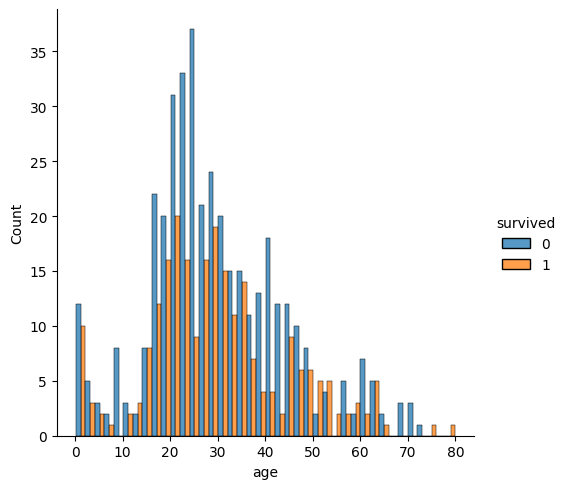

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=40)

In [ ]:
def age_group(age) :
  result = 0
  if age < 16 :
    result = 1
  else :
    result = 0
  return result 

train['age_group'] = train['age'].map(lambda x : age_group(x))
test['age_group'] = test['age'].map(lambda x : age_group(x))
ori_te['age_group'] = ori_te['age'].map(lambda x : age_group(x))
train.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0


## add family

In [ ]:
train['accompany'] = train['sibsp'] + train['parch']
test['accompany'] = test['sibsp'] + test['parch']
ori_te['accompany'] = ori_te['sibsp'] + ori_te['parch']
train.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group,accompany
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0,0
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0,0
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0,0
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1,0
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0,0


## add family_size

In [ ]:
def family(accompany) :
  result = 'alone'
  if accompany == 0 :
    result = 'alone'
  elif accompany >= 1 and accompany <= 3 :
    result = 'small'
  else :
    result = 'big'
  return result

train['family_size'] = train['accompany'].map(lambda x : family(x))
test['family_size'] = test['accompany'].map(lambda x : family(x))
ori_te['family_size'] = ori_te['accompany'].map(lambda x : family(x))

train.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group,accompany,family_size
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0,0,alone
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0,0,alone
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0,0,alone
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1,0,alone
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0,0,alone


## add parents

In [ ]:
def add_parents(age, parch):
    result = "Other"
    try:
        if (parch ==1 or parch==2) and (age>=20 or age<=40):
            result = "pc_" + str(parch)
    except:
        pass
    return result

train['parents'] = train.apply(lambda row: add_parents(row['age'], row['parch']), axis=1)
test['parents'] = test.apply(lambda row: add_parents(row['age'], row['parch']), axis=1)
ori_te['parents'] = ori_te.apply(lambda row: add_parents(row['age'], row['parch']), axis=1)

print(f"{train['parents'].nunique()} / \n {train['parents'].unique()} \n")
print(train['parents'].value_counts())
train.head()

3 / 
 ['Other' 'pc_2' 'pc_1'] 

Other    520
pc_1      73
pc_2      48
Name: parents, dtype: int64


,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group,accompany,family_size,parents
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0,0,alone,Other
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0,0,alone,Other
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0,0,alone,Other
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1,0,alone,Other
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0,0,alone,Other


In [ ]:
# train.drop(['sibsp','parch'], axis=1, inplace=True)
# test.drop(['sibsp','parch'], axis=1, inplace=True)
# ori_te.drop(['sibsp','parch'], axis=1, inplace=True)

## add fare_group

In [ ]:
train['fare'].describe()

count    641.000000
mean      31.654446
std       49.827609
min        0.000000
25%        7.895800
50%       14.400000
75%       30.000000
max      512.329200
Name: fare, dtype: float64

In [ ]:
def fare_group(fare):
  result = 0
  if fare <= 7.895800:
    result = 0
  elif fare <= 14.400000:
    result = 1
  elif fare <= 30.000000:
    result = 2
  else:
    result = 3
  return result

train['fare_group'] = train['fare'].map(lambda x : fare_group(x))
test['fare_group'] = test['fare'].map(lambda x : fare_group(x))
ori_te['fare_group'] = ori_te['fare'].map(lambda x : fare_group(x))

train.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group,accompany,family_size,parents,fare_group
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0,0,alone,Other,0
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0,0,alone,Other,0
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0,0,alone,Other,0
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1,0,alone,Other,2
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0,0,alone,Other,1


## add have_cabin

In [ ]:
train['cabin'].nunique(), train['cabin'].notnull().sum()

(110, 135)

In [ ]:
train['have_cabin'] = 1
train.loc[train['cabin'].isnull(),'have_cabin'] = 0

test['have_cabin'] = 1
test.loc[test['cabin'].isnull(),'have_cabin'] = 0

ori_te['have_cabin'] = 1
ori_te.loc[ori_te['cabin'].isnull(),'have_cabin'] = 0

train.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,gender_pclass,designation,age_group,accompany,family_size,parents,fare_group,have_cabin
812,1,3,female,22.0,0,0,7.7750,NaN,S,female_3,Miss.,0,0,alone,Other,0,0
134,0,3,male,21.0,0,0,7.8208,NaN,Q,male_3,Mr.,0,0,alone,Other,0,0
390,1,3,male,32.0,0,0,7.8542,NaN,S,male_3,Mr.,0,0,alone,Other,0,0
305,0,3,male,11.0,0,0,18.7875,NaN,C,male_3,Mr.,1,0,alone,Other,2,0
203,0,3,male,30.0,0,0,8.0500,NaN,S,male_3,Mr.,0,0,alone,Other,1,0


In [ ]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

# X, y split

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((641, 15), (641,), (275, 15), (275,))

# Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scale = StandardScaler().fit(train[['fare']])

train['fare'] = scale.transform(train[['fare']])
test['fare'] = scale.transform(test[['fare']])
ori_te['fare'] = scale.transform(ori_te[['fare']])

In [ ]:
scale = StandardScaler().fit(train[['age']])

train['age'] = scale.transform(train[['age']])
test['age'] = scale.transform(test[['age']])
ori_te['age'] = scale.transform(ori_te[['age']])

# One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_tr.columns

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked',
       'gender_pclass', 'designation', 'age_group', 'accompany', 'family_size',
       'parents', 'fare_group', 'have_cabin'],
      dtype='object')

In [ ]:
enc_cols = ['pclass', 'gender', 'sibsp', 'parch', 'embarked',
       'gender_pclass', 'designation', 'age_group', 'accompany', 'family_size',
       'fare_group', 'have_cabin', 'parents'] # 문자 컬럼
normal_cols = list(set(X_tr.columns) - set(enc_cols)) # 집합 사용해 수치형 컬럼만 빼기
normal_cols

['fare', 'age']

In [ ]:
print(f'before: {X_tr.shape} / {X_te.shape}')

enc = OneHotEncoder()
# X_tr
tmp_tr = pd.DataFrame(
    enc.fit_transform(X_tr[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [X_tr[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)],
    axis=1
)

# X_te
tmp_te = pd.DataFrame(
    enc.transform(X_te[enc_cols]).toarray(), # 앞서 tr으로 fit한걸 사용해서 그냥 변환만 함
    columns = enc.get_feature_names_out() 
)
enc_te = pd.concat(
    [X_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)],
    axis=1
)

#ori_te
tmp_ote = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_ote.reset_index(drop=True)],
    axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')
enc_tr.head()

before: (641, 15) / (275, 15)
after: (641, 59) / (275, 59)


,fare,age,pclass_1,pclass_2,pclass_3,gender_female,gender_male,sibsp_0,sibsp_1,sibsp_2,...,family_size_small,fare_group_0,fare_group_1,fare_group_2,fare_group_3,have_cabin_0,have_cabin_1,parents_Other,parents_pc_1,parents_pc_2
0,7.7750,22.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.8208,21.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,7.8542,32.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,18.7875,11.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,8.0500,30.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# Training

In [ ]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

def confusion(actual, pred):
  preds_1d = pred.flatten() # 차원 펴주기
  pred_class = np.where(preds_1d > 0.5, 1 , 0) 

  cm = confusion_matrix(actual, pred_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='PuBu')

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=args.random_state).fit(enc_tr, y_tr)

print(f'훈련용 평가지표: {lr.score(enc_tr, y_tr)} / 테스트용 평가지표: {lr.score(enc_te, y_te)}')

훈련용 평가지표: 0.8689547581903276 / 테스트용 평가지표: 0.8836363636363637


In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred_lr = lr.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_lr)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9064608636977058


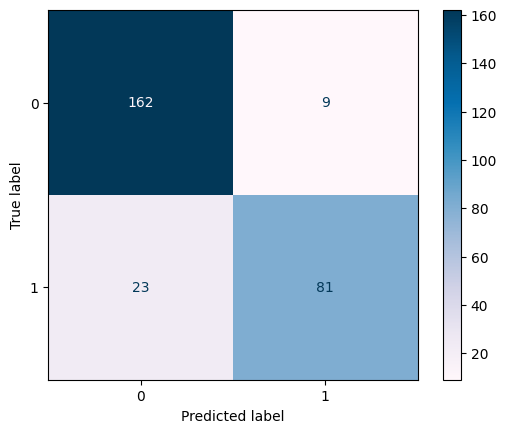

In [ ]:
confusion(y_te, y_pred_lr)

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
forest = RandomForestClassifier(random_state=args.random_state).fit(enc_tr, y_tr)
print(f'훈련용 평가지표: {forest.score(enc_tr, y_tr)} / 테스트용 평가지표: {forest.score(enc_te, y_te)}')

훈련용 평가지표: 0.9906396255850234 / 테스트용 평가지표: 0.8363636363636363


In [ ]:
y_pred_forest = forest.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_forest)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8981668915879444


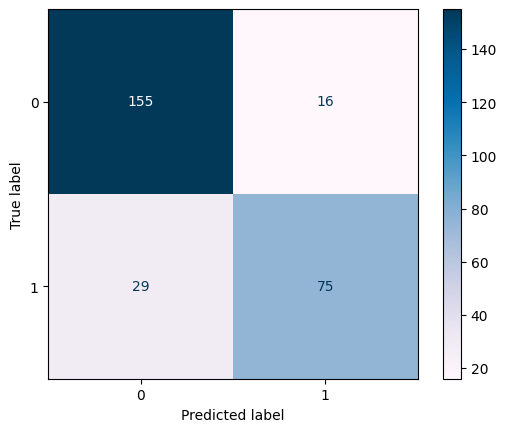

In [ ]:
confusion(y_te, y_pred_forest)

## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gradient = GradientBoostingClassifier(random_state=args.random_state).fit(enc_tr, y_tr)
print(f'훈련용 평가지표: {gradient.score(enc_tr, y_tr)} / 테스트용 평가지표: {gradient.score(enc_te, y_te)}')

훈련용 평가지표: 0.9126365054602185 / 테스트용 평가지표: 0.8581818181818182


In [ ]:
y_pred_gradient = gradient.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_gradient)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.905195681511471


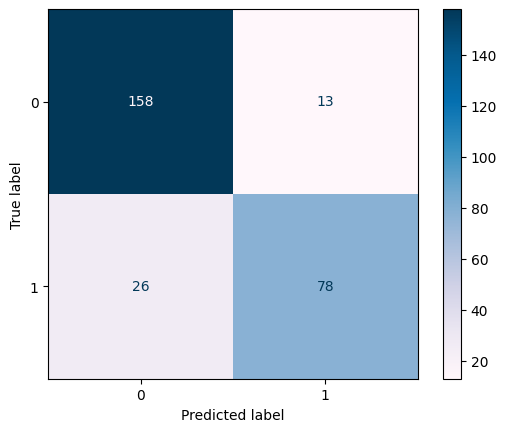

In [ ]:
confusion(y_te, y_pred_gradient)

## XGBoost

In [ ]:
from xgboost import XGBClassifier, plot_importance

In [ ]:
xgb = XGBClassifier(random_state=args.random_state).fit(enc_tr, y_tr)
print(f'훈련용 평가지표 : {xgb.score(enc_tr, y_tr)} / 테스트용 평가지표 : {xgb.score(enc_te, y_te)}')

훈련용 평가지표 : 0.9875195007800313 / 테스트용 평가지표 : 0.8181818181818182


In [ ]:
y_pred_xgb = xgb.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_xgb)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.8739035087719299


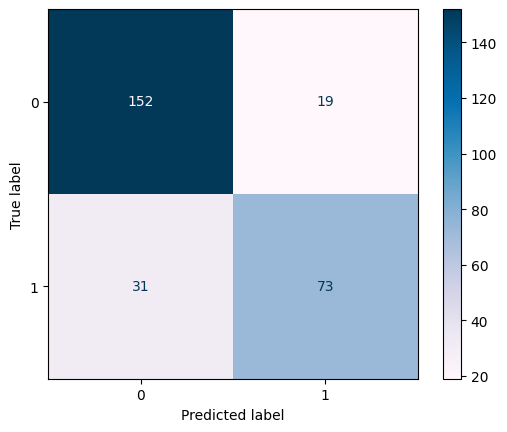

In [ ]:
confusion(y_te, y_pred_xgb)

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

In [ ]:
lgb = LGBMClassifier(random_state=args.random_state).fit(enc_tr, y_tr)
print(f'훈련용 평가지표 : {lgb.score(enc_tr, y_tr)} / 테스트용 평가지표 : {lgb.score(enc_te, y_te)}')

훈련용 평가지표 : 0.9750390015600624 / 테스트용 평가지표 : 0.8290909090909091


In [ ]:
y_pred_lgb = lgb.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_lgb)
auc_te = auc(fpr, tpr)
print(auc_te)

0.8808760683760685


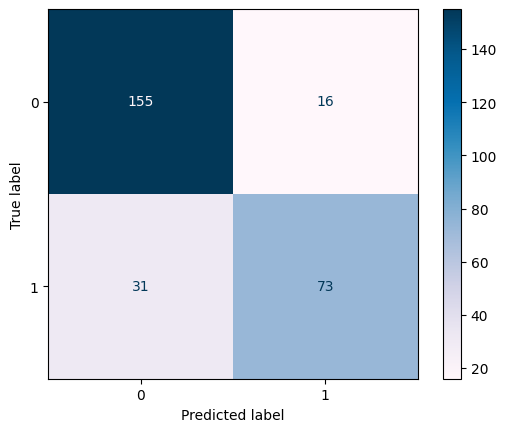

In [ ]:
confusion(y_te, y_pred_lgb)

## CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cb = CatBoostClassifier(random_state=args.random_state, verbose=False).fit(enc_tr, y_tr)
print(f'훈련용 평가지표 : {cb.score(enc_tr, y_tr)} / 테스트용 평가지표 : {cb.score(enc_te, y_te)}')

훈련용 평가지표 : 0.9173166926677067 / 테스트용 평가지표 : 0.8654545454545455


In [ ]:
y_pred_cb = cb.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred_cb)
auc_te = auc(fpr, tpr)
print(auc_te)

0.9069669365721998


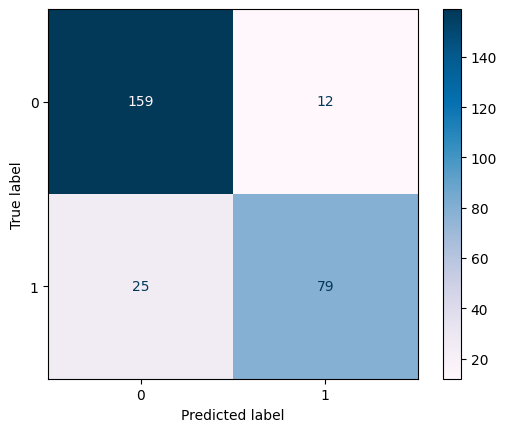

In [ ]:
confusion(y_te, y_pred_cb)

## Stratified K-Fold Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=args.random_state)

In [ ]:
n_iter = 0
auc_list = []
methods = [forest, gradient, xgb, lgb, cb]

for method in methods :
  for train_index, valid_index in skf.split(enc_tr, y_tr) :
    n_iter += 1

    train_x, valid_x = enc_tr.iloc[train_index], enc_tr.iloc[valid_index]
    train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]

    method.fit(enc_tr, y_tr)
    pred = method.predict(valid_x)

    fpr, tpr, thresholds = roc_curve(valid_y, pred)
    auc_te = auc(fpr, tpr)
    auc_list.append(auc_te)
  
  print(f'model : {method}')
  print(f'교차 검증 정확도 : {np.mean(auc_list)} / 모델 평가 : {method.score(enc_te, y_te)}')
  print('-'*50)

model : RandomForestClassifier(random_state=21)
교차 검증 정확도 : 0.9883333333333333 / 모델 평가 : 0.8363636363636363
--------------------------------------------------
model : GradientBoostingClassifier(random_state=21)
교차 검증 정확도 : 0.9448013540859381 / 모델 평가 : 0.8581818181818182
--------------------------------------------------
model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=No

## Bayesian Search

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

### TPESampler

In [ ]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [ ]:
class Objective:
    def __init__(self, x_train ,y_train, seed):
        self.x_train = enc_tr
        self.y_train = y_tr
        self.seed = args.random_state
        num_folds = 5 
        self.cv = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=self.seed)

    def __call__(self, trial):

        hp = {
            "max_depth" : trial.suggest_int("max_depth",1, 6),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.2)
        }

        forest =  RandomForestClassifier
        gradient = GradientBoostingClassifier
        xgb = XGBClassifier
        lgb = LGBMClassifier
        cb = CatBoostClassifier

        model = cb(random_state=self.seed,**hp, verbose=False)
        scores = cross_val_score(model, self.x_train, self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [ ]:
sampler = TPESampler(seed=args.random_state) 

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(enc_tr, y_tr, args.random_state)
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value) 
print("Best hp", study.best_params) 

Best Score: 0.91219095787049
Best hp {'max_depth': 2, 'n_estimators': 110, 'learning_rate': 0.06394917855582043}


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

In [ ]:
model = CatBoostClassifier(random_state=args.random_state, verbose=False, **study.best_params)
model.fit(enc_tr, y_tr)

pred = model.predict_proba(enc_te)[:,1]
roc_auc_score(y_te, pred)

0.9061797121007649

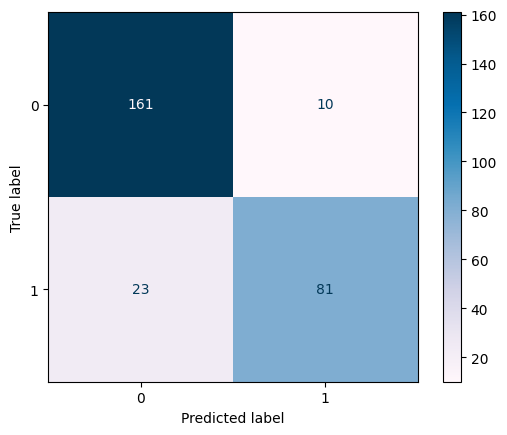

In [ ]:
confusion(y_te, pred)

In [ ]:
optuna.visualization.plot_param_importances(study)

## SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model) # 학습된 모델을 넣기
shap_values = explainer.shap_values(enc_te)

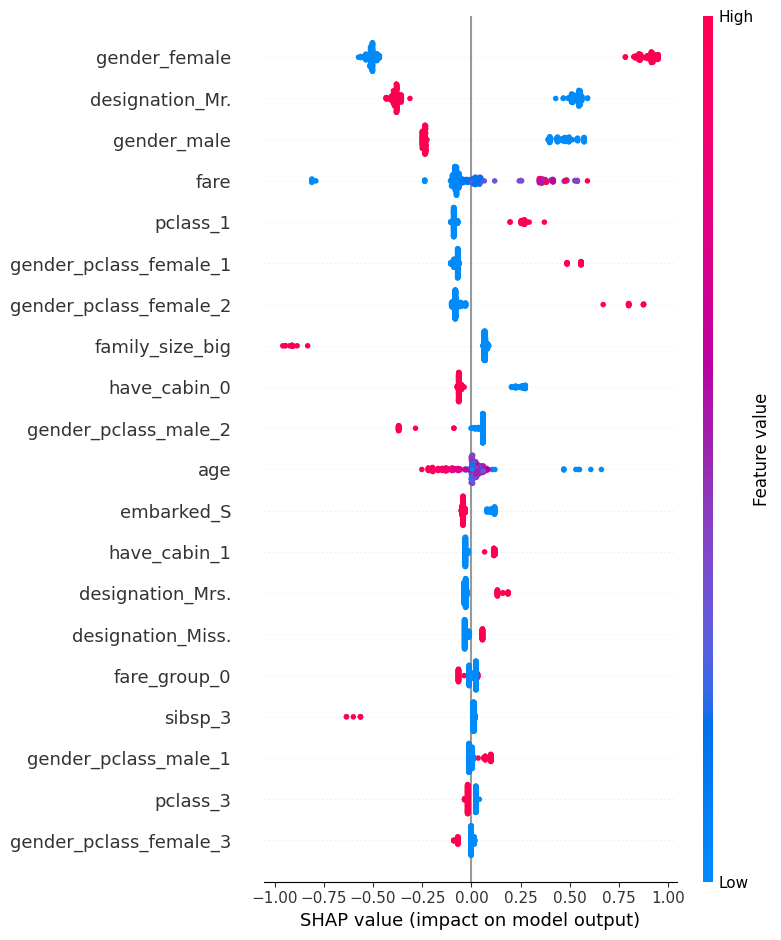

In [ ]:
shap.summary_plot(shap_values, enc_te)

# Submission

In [ ]:
submission = pd.read_csv(args.default_submission_csv)
print(f'{submission.shape}')
submission.head()

(393, 2)


,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
test_pred = model.predict_proba(enc_ori_te)[:, 1]
test_pred.shape

(393,)

In [ ]:
submission['survived'] = test_pred
submission

,passengerid,survived
0,916,0.643508
1,917,0.875048
2,918,0.685535
3,919,0.065521
4,920,0.883632
...,...,...
388,1304,0.685535
389,1305,0.919484
390,1306,0.668778
391,1307,0.386404


In [ ]:
args.submission_csv = args.default_path+'submission_final.csv'
submission.to_csv(args.submission_csv, header=True, index=False)